# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represents a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [1]:
import re
import torch

########## YOUR SOLUTION HERE ##########
class Encoder:
    def __init__(self, string):
        self.vocabulary = dict()
        for idx, elem in enumerate(string):
            self.vocabulary[elem] = idx
            
    def __call__(self, x):
        if isinstance(x, str):
            sample = list()
            for letter in x:
                found = False
                if not letter in self.vocabulary:
                    sample.append(self.vocabulary[' '])
                    continue
                sample.append(self.vocabulary[letter])
            sample = torch.tensor(sample)
            
        else:
            sample = ""
            for num in x:
                for key, value in self.vocabulary.items():
                    if int(num) == value:
                        sample += key
        return sample

## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [2]:
import torch
from torch.utils.data import Dataset
########## YOUR SOLUTION HERE ##########
class TextDataset(Dataset):
    def __init__(self, path, l):
        with open(path, "r", encoding="utf-8") as file:
            self.f = [text for text in file.read().splitlines() if text != ""]
            self.text = ("".join(map(str, self.f))).lower()
        
        self.samples = [enc(self.text[i:i+l]) for i in range(0, len(self.text), l)][:-1]
        self.targets = [(enc(self.text[i:i+l])) for i in range(1, len(self.text), l)][:-1]
        
    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.samples)

## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [3]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########
class NextCharLSTM(nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_dim):
        super(NextCharLSTM, self).__init__()
        self.embedding = nn.Embedding(alphabet_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim, alphabet_size)
    
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h, c) = self.lstm(embeds)
        logits = self.fc(lstm_out)

        return logits

## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [4]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def epoch(dataloader:torch.utils.data.DataLoader=None, model=None, optimizer=None):
  criterion = nn.CrossEntropyLoss().to(device)

  losses=list()

  iterations = 0

  if optimizer:
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        model.zero_grad()
        y_pred = model(X_batch.to(device))
        y_pred = (y_pred.reshape(-1, y_pred.shape[-1]))
        y_batch = (y_batch.reshape(-1)).to(device)
        loss = criterion(y_pred, y_batch)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        iterations += 1
    return losses, iterations

  else:
    for X_batch, y_batch in tqdm(dataloader):
      y_pred = model(X_batch.to(device))
      y_pred = (y_pred.reshape(-1, y_pred.shape[-1]))
      y_batch = (y_batch.reshape(-1)).to(device)
      loss = criterion(y_pred, y_batch)
      losses.append(loss.item())
      iterations += 1
    return losses, iterations

Mounted at /content/gdrive


## Exercise 5: Model Selection

Usually, we would now train and validate our model on a grid of with different hyperparameters to see which setting performs best. However, this is pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

100%|██████████| 1/1 [00:00<00:00, 44.17it/s]


epoch:  0 	 Training Loss Avg: 3.046574024593129 	 Validation Loss Avg: 2.860280752182007


100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


epoch:  1 	 Training Loss Avg: 2.7989549075855926 	 Validation Loss Avg: 2.7396278381347656


100%|██████████| 1/1 [00:00<00:00, 46.59it/s]


epoch:  2 	 Training Loss Avg: 2.6466933769338272 	 Validation Loss Avg: 2.617720365524292


100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


epoch:  3 	 Training Loss Avg: 2.520154090488658 	 Validation Loss Avg: 2.515422821044922


100%|██████████| 1/1 [00:00<00:00, 46.64it/s]


epoch:  4 	 Training Loss Avg: 2.410259443170884 	 Validation Loss Avg: 2.4259495735168457


100%|██████████| 1/1 [00:00<00:00, 46.35it/s]


epoch:  5 	 Training Loss Avg: 2.2980134767644547 	 Validation Loss Avg: 2.320683002471924


100%|██████████| 1/1 [00:00<00:00, 45.33it/s]


epoch:  6 	 Training Loss Avg: 2.1849043158923878 	 Validation Loss Avg: 2.2289962768554688


100%|██████████| 1/1 [00:00<00:00, 44.01it/s]


epoch:  7 	 Training Loss Avg: 2.0817428792224213 	 Validation Loss Avg: 2.1365807056427


100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


epoch:  8 	 Training Loss Avg: 1.991486742215998 	 Validation Loss Avg: 2.0609641075134277


100%|██████████| 1/1 [00:00<00:00, 45.51it/s]


epoch:  9 	 Training Loss Avg: 1.9129073374411638 	 Validation Loss Avg: 1.9955270290374756


100%|██████████| 1/1 [00:00<00:00, 40.30it/s]


epoch:  10 	 Training Loss Avg: 1.8427228857489193 	 Validation Loss Avg: 1.9377632141113281


100%|██████████| 1/1 [00:00<00:00, 41.60it/s]


epoch:  11 	 Training Loss Avg: 1.7805309611208298 	 Validation Loss Avg: 1.8855371475219727


100%|██████████| 1/1 [00:00<00:00, 44.78it/s]


epoch:  12 	 Training Loss Avg: 1.725636264857124 	 Validation Loss Avg: 1.8387986421585083


100%|██████████| 1/1 [00:00<00:00, 44.83it/s]


epoch:  13 	 Training Loss Avg: 1.6763778223710901 	 Validation Loss Avg: 1.7938318252563477


100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


epoch:  14 	 Training Loss Avg: 1.6312861582812141 	 Validation Loss Avg: 1.7542736530303955


100%|██████████| 1/1 [00:00<00:00, 39.43it/s]


epoch:  15 	 Training Loss Avg: 1.5905574244611405 	 Validation Loss Avg: 1.7184189558029175


100%|██████████| 1/1 [00:00<00:00, 44.48it/s]


epoch:  16 	 Training Loss Avg: 1.552950077197131 	 Validation Loss Avg: 1.6845314502716064


100%|██████████| 1/1 [00:00<00:00, 43.30it/s]


epoch:  17 	 Training Loss Avg: 1.5180202652426327 	 Validation Loss Avg: 1.6540298461914062


100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


epoch:  18 	 Training Loss Avg: 1.4861367590287153 	 Validation Loss Avg: 1.626146674156189


100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


epoch:  19 	 Training Loss Avg: 1.4567442711661844 	 Validation Loss Avg: 1.6008535623550415


100%|██████████| 1/1 [00:00<00:00, 44.24it/s]


epoch:  20 	 Training Loss Avg: 1.4296351040110868 	 Validation Loss Avg: 1.577710747718811


100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


epoch:  21 	 Training Loss Avg: 1.4046776259646696 	 Validation Loss Avg: 1.5563254356384277


100%|██████████| 1/1 [00:00<00:00, 37.88it/s]


epoch:  22 	 Training Loss Avg: 1.3817710525849287 	 Validation Loss Avg: 1.5363706350326538


100%|██████████| 1/1 [00:00<00:00, 42.06it/s]


epoch:  23 	 Training Loss Avg: 1.360950634760015 	 Validation Loss Avg: 1.5178158283233643


100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


epoch:  24 	 Training Loss Avg: 1.3422640246503494 	 Validation Loss Avg: 1.5030779838562012


100%|██████████| 1/1 [00:00<00:00, 41.48it/s]


epoch:  25 	 Training Loss Avg: 1.3243556408321155 	 Validation Loss Avg: 1.4892436265945435


100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


epoch:  26 	 Training Loss Avg: 1.305758371072657 	 Validation Loss Avg: 1.4729613065719604


100%|██████████| 1/1 [00:00<00:00, 41.94it/s]


epoch:  27 	 Training Loss Avg: 1.28921039314831 	 Validation Loss Avg: 1.4606788158416748


100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


epoch:  28 	 Training Loss Avg: 1.2734793915468103 	 Validation Loss Avg: 1.4488863945007324


100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


epoch:  29 	 Training Loss Avg: 1.2583090522710014 	 Validation Loss Avg: 1.438180923461914


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch')]

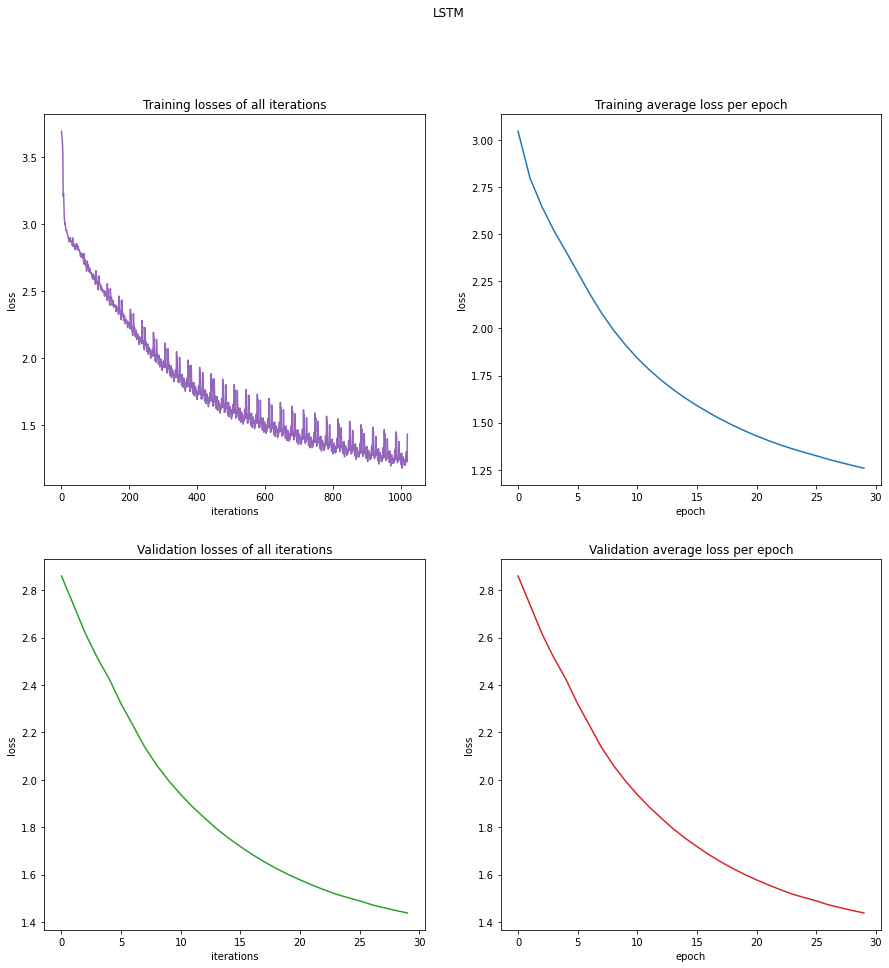

In [ ]:
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 30

char = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
enc = Encoder(char)

path_train = "/content/gdrive/MyDrive/lstm/trump_train.txt"
path_val = "/content/gdrive/MyDrive/lstm/trump_val.txt"

train = TextDataset(path_train, sequence_length)
val = TextDataset(path_val, sequence_length)

train_loader = DataLoader(train, batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size, shuffle=False)

model = NextCharLSTM(len(char), embedding_dim, hidden_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_epoch_losses = list()
val_epoch_losses = list()

for e in range(num_epochs):
  # train_losses: list with losses of each mini batch of an epoch
  train_losses, train_iterations = epoch(train_loader, model, optimizer)
  val_losses, val_iterations = epoch(val_loader, model)
  # train_avg: loss average of one epoch
  train_avg = float(np.mean([float(loss) for loss in train_losses]))
  val_avg = float(np.mean([float(loss) for loss in val_losses]))
  
  train_epoch_losses.append((train_losses, train_iterations, train_avg))
  val_epoch_losses.append((val_losses, val_iterations, val_avg))

  print("epoch: ", e,"\t Training Loss Avg:", train_avg, "\t Validation Loss Avg:", val_avg)

save_path = "/content/gdrive/MyDrive/lstm/lstm_model_nlp.pth"
torch.save(model.state_dict(), save_path)

it_train = np.sum([i[1] for i in train_epoch_losses])
all_train_losses = list()
all_train_avg = list()

for e in train_epoch_losses:
  for l in e[0]:
    all_train_losses.append(l)
  all_train_avg.append(e[2])

it_val = np.sum([i[1] for i in val_epoch_losses])
all_val_losses = list()
all_val_avg = list()

for e in val_epoch_losses:
  for l in e[0]:
    all_val_losses.append(l)
  all_val_avg.append(e[2])

fig, axs = plt.subplots(2,2, figsize=(15, 15))
fig.suptitle('LSTM')

axs[0, 0].plot(range(it_train), all_train_losses, 'tab:purple')
axs[0, 0].set_title('Training losses of all iterations')
axs[0, 0].set(xlabel='iterations', ylabel='loss')
axs[0, 1].plot(range(len(all_train_avg)), all_train_avg, 'tab:blue')
axs[0, 1].set_title('Training average loss per epoch')
axs[0, 1].set(xlabel='epoch', ylabel='loss')
axs[1, 0].plot(range(it_val), all_val_losses, 'tab:green')
axs[1, 0].set_title('Validation losses of all iterations')
axs[1, 0].set(xlabel='iterations', ylabel='loss')
axs[1, 1].plot(range(len(all_val_avg)), all_val_avg, 'tab:red')
axs[1, 1].set_title('Validation average loss per epoch')
axs[1, 1].set(xlabel='epoch', ylabel='loss')


## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Text(0, 0.5, 'accuracy')

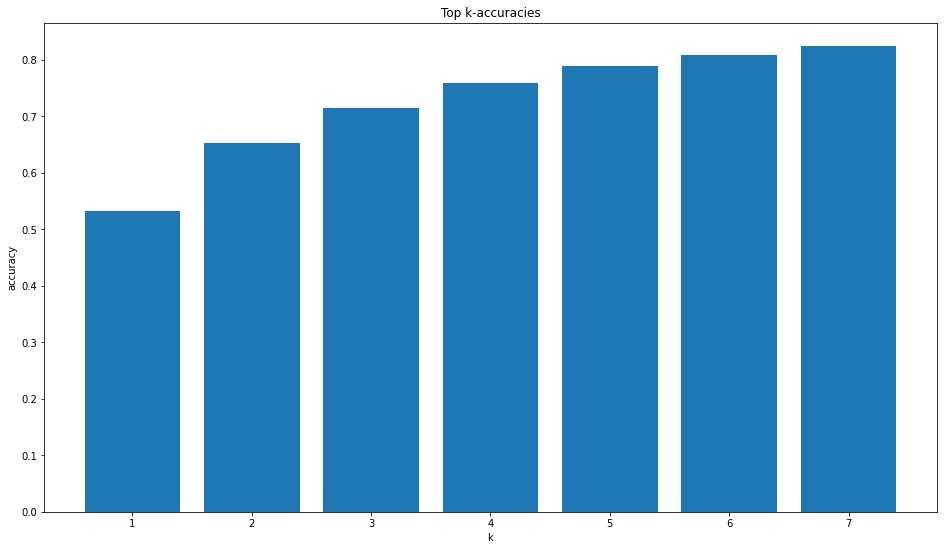

In [ ]:
import matplotlib.pyplot as plt

save_path = r"/content/gdrive/MyDrive/unistuff/WS 2022/lstm/lstm_model_nlp.pth"
checkpoint = torch.load(save_path)

embedding_dim = 8
hidden_dim = 512
sequence_length = 100
batch_size = 256
char = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
enc = Encoder(char)

model = NextCharLSTM(len(char), embedding_dim, hidden_dim).to(device)
model.load_state_dict(checkpoint)

model.eval()
path_val = r"/content/gdrive/MyDrive/unistuff/WS 2022/lstm/trump_val.txt"
val = TextDataset(path_val, sequence_length)

val_loader = DataLoader(val, batch_size, shuffle=False)

def topk_accuracy(k_array, model, dataloader):
  acc = list()
  
  for k in k_array:
    correct = 0

    for X_batch, y_batch in tqdm(dataloader):
        y_pred = model(X_batch.to(device))
        for frame_idx, x in enumerate(y_pred):
          for row_idx, row in enumerate(x):
            prob = row.softmax(0)
            ind = prob.argsort()[-k:]
            if int(y_batch[frame_idx, row_idx]) in ind:
              correct += 1

    acc.append(correct / (batch_size * sequence_length))

  return acc

ks = list(range(1,8))
acc = topk_accuracy(ks, model, val_loader)

plt.figure(figsize=(16,9))
plt.bar(ks, acc)
plt.title("Top k-accuracies")
plt.xlabel("k")
plt.ylabel("accuracy")

## Exercise 7: Gumbel-Max Character Sampling

In this exercise we utilize the trained network to generate novel text. To do this, take some string of seed text, which you can choose freely, and feed it to the network. For each subsequent character, the model outputs logits $z = (z_1, \dots, z_K)^\top$, where $K$ is the alphabet size. 

Use the Gumbel-Max trick to sample from the categorical distribution parameterized by 
$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}} \quad \text{where} \quad \tau > 0 
$$
is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable 
$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$
follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently from the standard Gumbel distribution.

Implement next-character sampling using the Gumbel-Max trick. Try out different values of $\tau$ and see which work best. 

In [7]:
save_path = r"/content/gdrive/MyDrive/lstm/lstm_model_nlp.pth"
checkpoint = torch.load(save_path)

embedding_dim = 8
hidden_dim = 512
sequence_length = 100
batch_size = 256
char = "abcdefghijklmnopqrstuvwxyz0123456789 .!?"
enc = Encoder(char)

model = NextCharLSTM(len(char), embedding_dim, hidden_dim).to(device)
model.load_state_dict(checkpoint)

model.eval()
initial_text = "We will make America great again!"
prediction = ""
enc_text = enc(initial_text)
y_pred = model(enc_text.to(device))

temp = 345
xi = np.random.gumbel(size=1)

for logits in y_pred:
  prob = torch.exp(logits / (temp + float(xi)))
  pi = prob / torch.sum(prob)
  Y = int(torch.argmax(pi))
  f = [Y]
  prediction += enc(f)

prediction

"""Observation: The lower the temperature the more 
likely the last few indexes of the probabilites get higher.
The higher the temperature the more it converges to 
fixed sequences of characters
"""

'Observation: The lower the temperature the more \nlikely the last few indexes of the probabilites get higher.\nThe higher the temperature the more it converges to \nfixed sequences of characters\n'

## Exercise 8: Huffman Coding using LSTM

*Thanks to Philipp Renz who had this idea.*

The Huffman code is an algorithm to compress data. It encodes symbols with different lengths depending on their frequencies. It assigns a short code to frequent symbols and a longer code to rare symbols to minimize the average code length. We provide you with an implementation that given a list of frequencies `freqs` returns a list of their respective binary codes as strings in the same order. In fact, `freqs` may contain any real numbers. 

With a model that predicts the next symbol we can achieve even shorter codes. At every time step we can use the predicted probabilities as frequencies for the Huffman code. That is, we use a new code at every time step. This code is governed by the model's belief what the next symbol will be. If the model predictions are good, we will mostly use very short codes.

First, determine the average code length per symbol on the validation set using frequencies determined on the training set. 
Then, use the prediction probabilities of your trained LSTM and determine the average code length per symbol on the validation set using an adaptable code. Add a temperature to the softmax and tune it. How many bits per symbol can you save by using the LSTM and what is the optimal temperature? 

In [9]:
from heapq import heapify, heappop, heappush
from tqdm import tqdm

def huffman_code(freqs):
    """This function turns a list of frequencies into a Huffman code. """
    heap = list(zip(freqs, [(i,) for i in range(len(freqs))]))
    heapify(heap)
    code = [''] * len(freqs)
    
    while len(heap) > 1:
        freq0, idx0 = heappop(heap)
        freq1, idx1 = heappop(heap)
        heappush(heap, (freq0 + freq1, idx0 + idx1))
        
        for i in idx0:
            code[i] = '0' + code[i]
        
        for i in idx1:
            code[i] = '1' + code[i]
    
    return code

########## YOUR SOLUTION HERE ##########

path_train = "/content/gdrive/MyDrive/lstm/trump_train.txt"
path_val = "/content/gdrive/MyDrive/lstm/trump_val.txt"

with open(path_train, "r", encoding="utf-8") as f:
  text = f.read()
  counts = [text.count(ch) for ch in char]
# 1) attain training set frequency per character
train_freq = np.array(counts) / sum(counts)
# 2) use training frequencies huffman coding to determine validation set bit length
with open(path_val, "r", encoding="utf-8") as f:
  text = f.read().lower()

counts = [text.count(ch) for ch in char]
huff_train = huffman_code(train_freq)
code_length = list()

for count, huff in zip(counts, huff_train):
  code_length.append(count * len(huff))

code_len_per_symbol_val = float(np.sum(code_length) / len(text))

# 3) lstm prob softmax temperature huffman coding
out = model(enc(text).to(device))

temp = [0,0.5,1,2,5,10,100,1000]
xi = np.random.gumbel(size=1)
lstm_all_len = list()

for t in temp:
  lstm_code = ""
  
  for row in tqdm(out):
    prob = torch.exp(row / (t + float(xi)))
    pi = prob / torch.sum(prob)
    pred_char = torch.argmax(prob)
    freq = huffman_code(pi)
    lstm_code += freq[pred_char]

  len_per_symbol = len(lstm_code) / len(text)
  lstm_all_len.append(len_per_symbol)

tau_dict = dict()
for tau, len_sym in zip(temp, lstm_all_len):
  tau_dict[tau] = len_sym

print("\nval set bit length code with train freq: ",code_len_per_symbol_val) 
print("val set bit length with lstm output with tau:\n", tau_dict)

100%|██████████| 23687/23687 [06:47<00:00, 58.11it/s]


val set bit length code with train freq:  4.146198336640351
val set bit length with lstm output with tau:
 {0: 3.692658420230506, 0.5: 1.0947777261789167, 1: 1.3671634229746275, 2: 2.045088022966184, 5: 3.502765229872926, 10: 4.311141132266644, 100: 5.0, 1000: 5.0}


Observation: best temperature is here 0.5 where we get shortest average bit code length per symbol, while starting with temperature being 10 sequence length converges to 5